# CSE 252A Computer Vision I Fall 2019 - Homework 3
## Instructor: Ben Ochoa
### Assignment published on: Tuesday, October 22, 2019
### Due on: Tuesday, November 5, 2019 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
  * This assignment must be completed individually.
* All solutions must be written in this notebook.
  * This includes the theoretical problems, for which you **must** write your answers in Markdown cells (using LaTeX when appropriate).
  * Programming aspects of the assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you may do so. It has only been provided as a framework for your solution.
* You may use Python packages (such as NumPy and SciPy) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy: assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.**

## Problem 1: Photometric Stereo, Specularity Removal [20 pts]

The goal of this problem is to implement a couple of different algorithms that reconstruct a surface using the concept of Lambertian photometric stereo. Additionally, you will implement the specular removal technique of [Mallick et al.](http://www.eecs.harvard.edu/~zickler/download/photodiff_cvpr05_preprint.pdf), which enables photometric stereo to be performed on certain non-Lambertian materials.

You can assume a Lambertian reflectance function once specularities are removed. However, note that the albedo is unknown and non-constant in the images you will use.

As input, your program should take in multiple images along with the light source direction for each image. Each image is associated with only a single light, and hence a single direction.

### Data
You will use synthetic images and specular sphere images as data. These images are stored in `.pickle` files which have been graciously provided by Satya Mallick. Each `.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.

### Part 1: Lambertian Photometric Stereo [8 pts]

Implement the photometric stereo technique described in the lecture slides and in Forsyth and Ponce 2.2.4 (*Photometric Stereo: Shape from Multiple Shaded Images*). Your program should have two parts:

1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals. You should first try the naive scanline-based "shape by integration" method described in the book and in lecture. (You are required to implement this.) For comparison, you should also integrate using the Horn technique which is already implemented for you in the `horn_integrate` function. Note that for good results you will often want to run the `horn_integrate` function with 10000-100000 iterations, which will take a while. For your final submission, we will require that you run Horn integration for 1000 (one thousand) iterations or more in each case. But for debugging, it is suggested that you keep the number of iterations low.

You will find all the data for this part in `synthetic_data.pickle`. Try using only `im1`, `im2` and `im4` first. Display your outputs as mentioned below.

Then use all four images (most accurate).

For **each** of the **two above cases** you must output:

1. The estimated albedo map.

1. The estimated surface normals by showing both
    1. Needle map, and
    1. Three images showing each of the surface normal components.

1. A wireframe of the depth map given by the scanline method.

1. A wireframe of the depth map given by Horn integration.

In total, we expect 2 * 7 = 14 images for this part.

An example of outputs is shown in the figure below. (The example outputs only include one depth map, although we expect two – see above.)

![Problem 1.1 example outputs](problem1_example.png)

Keys:  ['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3']

Image 1:


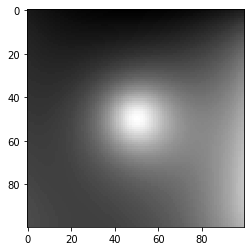

Light source direction: [[0 0 1]]

Image 2:


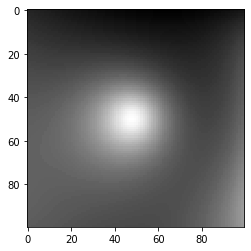

Light source direction: [[0.2 0.  1. ]]

Image 3:


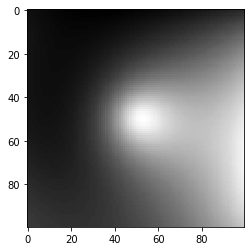

Light source direction: [[-0.2  0.   1. ]]

Image 4:


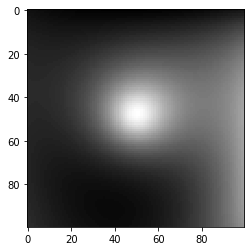

Light source direction: [[0.  0.2 1. ]]


In [2]:
# Setup
import pickle
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

### Example: how to read and access data from a .pickle file
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: ", list(data.keys()))

# To access the value of an entity, refer to it by its key.
for i in range(1, 5):
    print("\nImage %d:" % i)
    plt.imshow(data["im%d" % i], cmap="gray")
    plt.show()
    print("Light source direction: " + str(data["l%d" % i]))

Based on the above images, can you interpret the orientation of the coordinate frame? If we label the axes in order as x, y, z, then the x-axis points left, the y-axis points up, and the z-axis points out of the screen in our direction. (That means this is a left-handed coordinate system. How will this affect the scanline integration algorithm? Hint: if you integrate rightward along the x-axis and downward along the y-axis, you will be doing in opposite directions to the axes, and the partial derivatives you compute may need to be modified.)

_Note: as clarification, no direct response is needed for this cell._

In [3]:
import numpy as np
from scipy.signal import convolve

def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) 
        + term_right
    
    return g

In [4]:
A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1

d_mask = A + B + C + D
print(d_mask)
from scipy.signal import convolve

[[0 1 0]
 [1 0 1]
 [0 1 0]]


In [5]:
def photometric_stereo(images, lights, mask, horn_niter=25000):
    
    """mask is an optional parameter which you are encouraged to use.
    It can be used e.g. to ignore the background when integrating the normals.
    It should be created by converting the images to grayscale, averaging them,
    normalizing to [0, 1] and thresholding (only using locations for which the
    pixel value is above some threshold).
    
    The choice of threshold is something you can experiment with,
    but in practice something like 0.05 or 0.1 tends to work well.
    
    You do not need to use the mask for 1a (it shouldn't matter),
    but you SHOULD use it to filter out the background for the specular data (1c).
    """

    """ ==========
    YOUR CODE HERE
    ========== """

    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)
    
    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))
    H = np.ones(images[0].shape)
    H_horn = np.ones(images[0].shape)
    
    for i in range(images[0].shape[0]):
        for j in range(images[0].shape[1]):
            b_ij = np.linalg.multi_dot([np.linalg.inv(np.dot
                            (lights.T,lights)), lights.T, images[:,i,j]])
            albedo[i,j] = np.linalg.norm(b_ij)
            normals[i,j,:] = b_ij / albedo[i,j]
            
    p = -normals[:,:,0] / normals[:,:,2]
    q = -normals[:,:,1] / normals[:,:,2]
    
    p = p * mask
    q = q * mask
    
    H_horn = horn_integrate(-p, -q, mask, horn_niter)
    q[0,0] = 0
    q[:,0] = -np.sum(q[:,0])
    p = -p
    p[:,0] = q[:,0]
    for i in range(H.shape[0]):
        H[i,:] = np.cumsum(p[i,:])

    return albedo, normals, H, H_horn

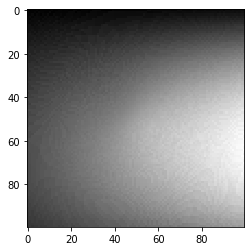

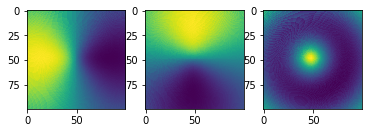

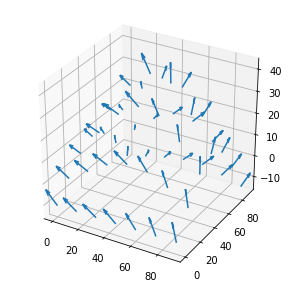

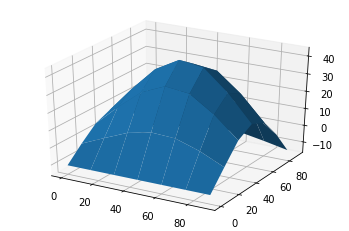

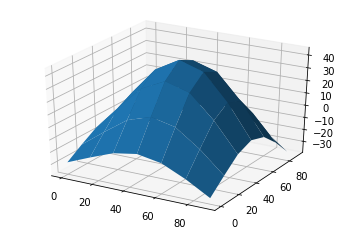

In [6]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
# images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights,
                                        mask, horn_niter = 20000)

# --------------------------------------------------------------------------
# The following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout. You are also free to change the function
# however you wish; just make sure you get all of the required outputs.
# --------------------------------------------------------------------------

def visualize(albedo, normals, depth, horn):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    plt.quiver(X,Y,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map
    H = depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

    H = horn[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

visualize(albedo, normals, depth, horn)

In [26]:
# Don't forget to run your photometric stereo code on TWO sets of images!
# (One being {im1, im2, im4}, and the other being {im1, im2, im3, im4}.)

### First set: { im1, im2, im4 }

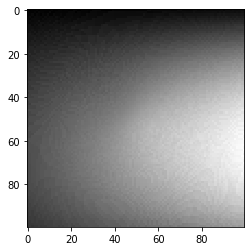

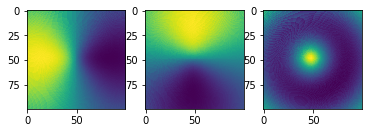

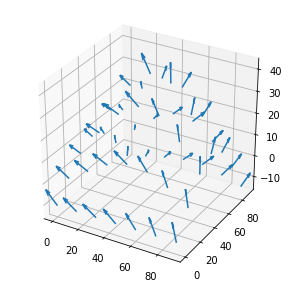

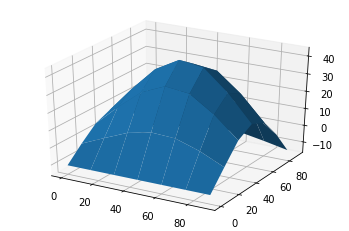

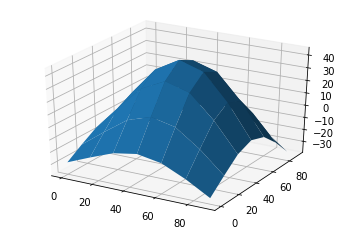

In [7]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
# images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights,
                                            mask, horn_niter = 20000)
visualize(albedo, normals, depth, horn)

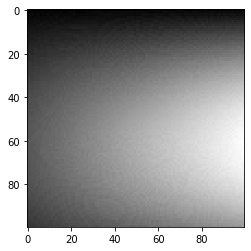

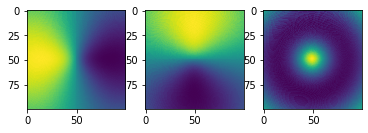

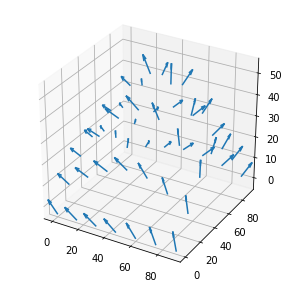

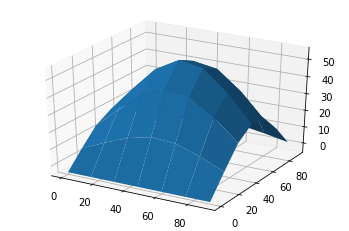

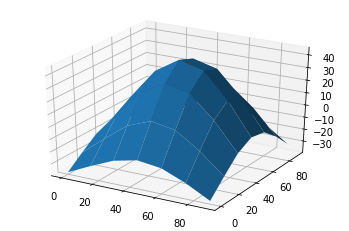

In [8]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"],data["l3"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, 
                                            mask,  horn_niter = 20000)
visualize(albedo, normals, depth, horn)

### Part 2: Specularity Removal [6 pts]

Implement the specularity removal technique described in *Beyond Lambert: Reconstructing Specular Surfaces Using Color* (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).

Your program should input an RGB image and light source color and output the corresponding SUV image.  

Try this out first with the specular sphere images and then with the pear images.  
  
For each of the specular sphere and pear images, include

1. The original image (in RGB colorspace).

1. The recovered $S$ channel of the image.

1. The recovered diffuse part of the image. Use $G = \sqrt{U^2+V^2}$ to represent the diffuse part.

In total, we expect 2 * 3 = 6 images as outputs for this problem.

Note: You will find all the data for this part in `specular_sphere.pickle` and `specular_pear.pickle`.

In [9]:
def get_rot_mat(rot_v, unit=None):
    '''
    Takes a vector and returns the rotation matrix required to align the
    unit vector(2nd arg) to it.
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) # axis of rotation
    
    rcos = np.dot(rot_v, unit) # cos by dot product
    rsin = np.linalg.norm(uvw) # sin by magnitude of cross product

    # normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    return R

def RGBToSUV(I_rgb, rot_vec):
    '''
    Your implementation which takes an RGB image and a vector encoding
    the orientation of the S channel w.r.t. to RGB.
    '''

    """ ==========
    YOUR CODE HERE
    ========== """
    S = np.ones(I_rgb.shape[:2])
    G = np.ones(I_rgb.shape[:2])
    I_suv = np.zeros(I_rgb.shape)
    R = get_rot_mat(rot_vec, unit= None)
    
    for i in range(I_rgb.shape[0]):
        for j in range(I_rgb.shape[1]):
            I_suv[i,j,:] = np.matmul(R,I_rgb[i,j,:])
    S = I_suv[:,:,0]
    G = np.sqrt(I_suv[:,:,1]**2 + I_suv[:,:,2]**2)
    
    return S, G



#### (1) Display sphere images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


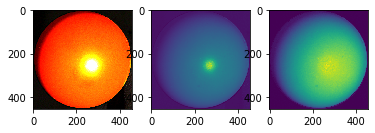

In [10]:
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
S, G = RGBToSUV(data["im1"], np.hstack((data["c"][0][0],
                                        data["c"][1][0],
                                        data["c"][2][0])))
plt.subplot(131)
plt.imshow(data["im1"]*255)
plt.subplot(132)
plt.imshow(S)
plt.subplot(133)
plt.imshow(G)
plt.show()

#### (2) Display pear images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


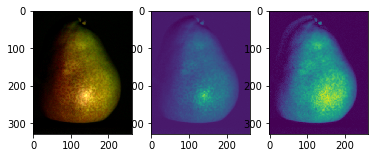

In [11]:
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
S, G = RGBToSUV(data["im1"], np.hstack((data["c"][0][0],
                                        data["c"][1][0],
                                        data["c"][2][0])))
plt.subplot(131)
plt.imshow(data["im1"]*255)
plt.subplot(132)
plt.imshow(S)
plt.subplot(133)
plt.imshow(G)
plt.show()

### Part 3: Robust Photometric Stereo [6 pts]

Now we will perform photometric stereo on our sphere/pear images which include specularities. First, for comparison, run your photometric stereo code from 1a on the original images (converted to grayscale and rescaled/shifted to be in the range [0, 1]). You should notice erroneous "bumps" in the resulting reconstructions, as a result of violating the Lambertian assumption. For this, show the same outputs as in 1a.

Next, combine parts 1 and 2 by removing the specularities (using your code from 1b) and then running photometric stereo on the diffuse components of the specular sphere/pear images. Our goal will be to remove the bumps/sharp parts in the reconstruction.

For the specular sphere image set in `specular_sphere.pickle`, using all of the four images (again, be sure to convert them to grayscale and normalize them so that their values go from 0 to 1), include:

1. The estimated albedo map (original and diffuse).

1. The estimated surface normals (original and diffuse) by showing both

    1. Needle map, and
    1. Three images showing each of the surface normal components.
    
1. A wireframe of depth map (original and diffuse).

1. A wireframe of the depth map given by Horn integration (original and diffuse).

In total, we expect 2 \* 7 = 14 images for the 1a comparison, plus 2 \* 7 = 14 images for the outputs after specularity removal has been performed. (Thus 28 output images overall.)

In [12]:
def rgb_to_gray(img):
    '''
    convert rgb to gray image
    '''
    gray = np.zeros((img.shape[0], img.shape[1]))
    gray = img[:,:,0]* 0.3 + img[:,:,1]* 0.59 + img[:,:,2] * 0.11
    return gray

def normalize(img):
    img_norm = (img - np.min(img))/ (np.max(img)- np.min(img))
    return img_norm
# ---------------------------------------------------------------------------
# You may reuse the code for photometric_stereo here.
# Write your code below to process the data and send it to photometric_stereo
# and display the albedo, normals, and depth maps.
# ---------------------------------------------------------------------------

#### Display original stereo image of sphere

Original stereo image of sphere: 


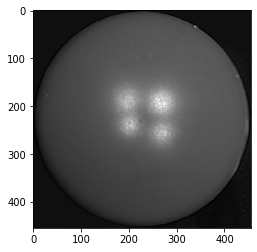

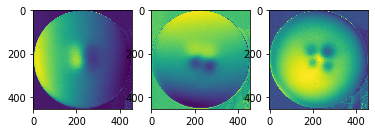

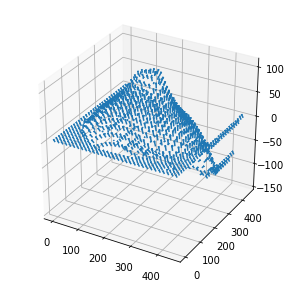

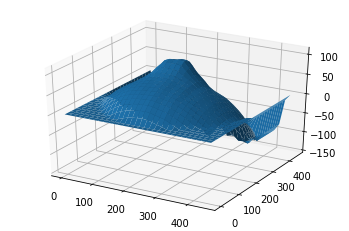

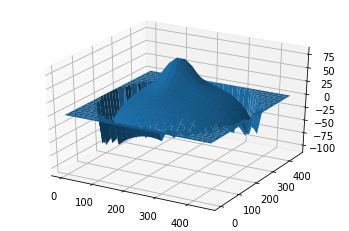

In [13]:
from mpl_toolkits.mplot3d import Axes3D
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
img_norm1 = normalize(rgb_to_gray(data["im1"]))
img_norm2 = normalize(rgb_to_gray(data["im2"]))
img_norm3 = normalize(rgb_to_gray(data["im3"]))
img_norm4 = normalize(rgb_to_gray(data["im4"]))

images.append(img_norm1)
images.append(img_norm2)
images.append(img_norm3)
images.append(img_norm4)
images = np.array(images)

mask = (img_norm1+ img_norm2+ img_norm3 + img_norm4) / 4
threshold = 0.07
mask[mask > threshold] = 1
mask[mask < threshold] = 0
#mask = np.ones((img_norm1.shape))
albedo, normals, depth, horn = photometric_stereo(images, lights, 
                                                  mask, horn_niter = 20000)
print("Original stereo image of sphere: ")
visualize(albedo, normals, depth, horn)

#### Robust Photometric stereo of sphere

Robust Photometric stereo image of sphere: 


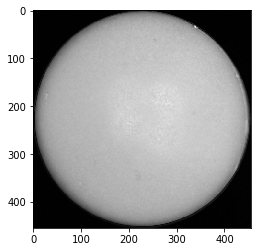

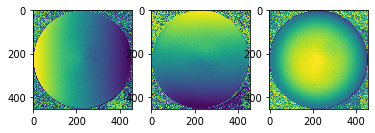

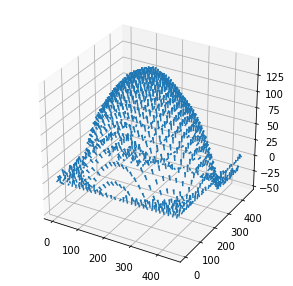

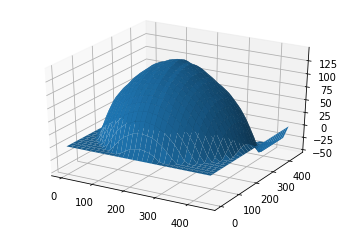

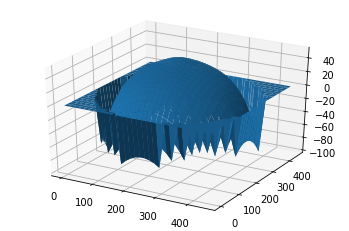

In [15]:
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

def get_diffuse(img, color):
    _, G = RGBToSUV(img,color)
    return G
color = np.hstack((data["c"][0][0],data["c"][1][0],data["c"][2][0]))

images = []
img_norm1 = normalize(get_diffuse(data["im1"], color))
img_norm2 = normalize(get_diffuse(data["im2"], color))
img_norm3 = normalize(get_diffuse(data["im3"], color))
img_norm4 = normalize(get_diffuse(data["im4"], color))

images.append(img_norm1)
images.append(img_norm2)
images.append(img_norm3)
images.append(img_norm4)
images = np.array(images)

mask = (img_norm1+ img_norm2+ img_norm3 + img_norm4) / 4
threshold = 0.07
mask[mask > threshold] = 1
mask[mask < threshold] = 0
#mask = np.ones((img_norm1.shape))
albedo, normals, depth, horn = photometric_stereo(images, lights,
                                                  mask, horn_niter = 20000)
print("Robust Photometric stereo image of sphere: ")
visualize(albedo, normals, depth, horn)

#### Display original stereo image of pear

Original stereo image of pear: 


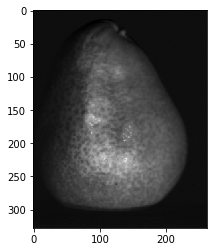

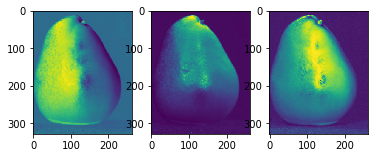

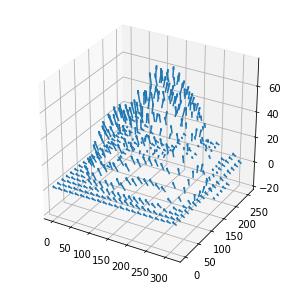

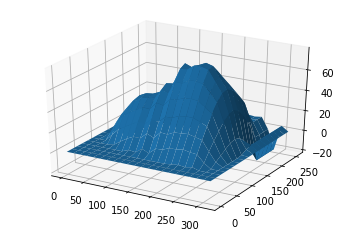

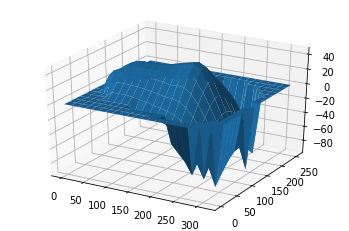

In [183]:
from mpl_toolkits.mplot3d import Axes3D
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
img_norm1 = normalize(rgb_to_gray(data["im1"]))
img_norm2 = normalize(rgb_to_gray(data["im2"]))
img_norm3 = normalize(rgb_to_gray(data["im3"]))
img_norm4 = normalize(rgb_to_gray(data["im4"]))

images.append(img_norm1)
images.append(img_norm2)
images.append(img_norm3)
images.append(img_norm4)
images = np.array(images)

mask = (img_norm1+ img_norm2+ img_norm3 + img_norm4) / 4
threshold = 0.07
mask[mask > threshold] = 1
mask[mask < threshold] = 0

albedo, normals, depth, horn = photometric_stereo(images, lights,
                                                  mask, horn_niter = 25000)
print("Original stereo image of pear: ")
visualize(albedo, normals, depth, horn)

#### Robust Photometric stereo of pear

Robust Photometric stereo image of pear: 


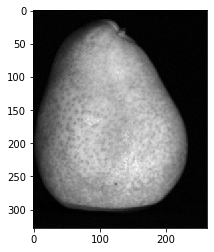

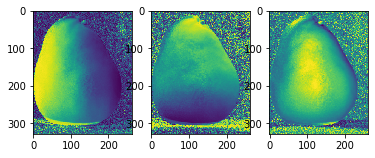

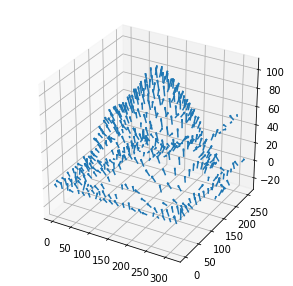

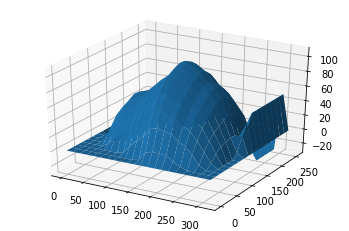

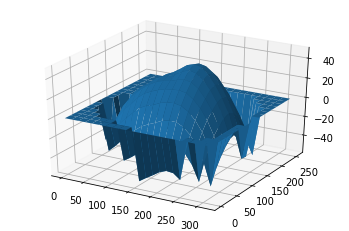

In [184]:
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

def get_diffuse(img, color):
    _, G = RGBToSUV(img,color)
    return G
color = np.hstack((data["c"][0][0],data["c"][1][0],data["c"][2][0]))

images = []
img_norm1 = normalize(get_diffuse(data["im1"], color))
img_norm2 = normalize(get_diffuse(data["im2"], color))
img_norm3 = normalize(get_diffuse(data["im3"], color))
img_norm4 = normalize(get_diffuse(data["im4"], color))

images.append(img_norm1)
images.append(img_norm2)
images.append(img_norm3)
images.append(img_norm4)
images = np.array(images)

mask = (img_norm1+ img_norm2+ img_norm3 + img_norm4) / 4
threshold = 0.07
mask[mask > threshold] = 1
mask[mask < threshold] = 0
#mask = np.ones((img_norm1.shape))
albedo, normals, depth, horn = photometric_stereo(images, lights,
                                                mask, horn_niter = 25000)
print("Robust Photometric stereo image of pear: ")
visualize(albedo, normals, depth, horn)

## Problem 2: Image Filtering [13 pts]

### Part 1: Warmup [1.5 pts]

In this problem, we expect you to use convolution to filter the provided image with three different types of kernels:

1. A 5x5 Gaussian filter with $\sigma = 5$.
2. A 31x31 Gaussian filter with $\sigma = 5$.
3. A sharpening filter.

This is the image you will be using:

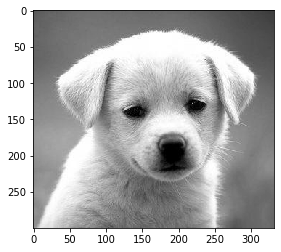

(300, 332)
1.0


In [26]:
# Open image as grayscale
dog_img = io.imread('dog.jpg', as_gray=True)

# Show image
plt.imshow(dog_img, cmap='gray')
plt.show()
print(dog_img.shape)
print(dog_img.max())

For convenience, we have provided a helper function for creating a square isotropic Gaussian kernel. We have also provided the sharpening kernel that you should use. Finally, we have provided a function to help you plot the original and filtered results side-by-side. Take a look at each of these before you move on.

In [20]:
def gaussian2d(filter_size=5, sig=1.0):
    """Creates a 2D Gaussian kernel with
    side length `filter_size` and a sigma of `sig`."""
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy))
                    / np.square(sig))
    return kernel / np.sum(kernel)

sharpening_kernel = np.array([
    [1, 4,     6,  4, 1],
    [4, 16,   24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16,   24, 16, 4],
    [1,  4,    6,  4, 1],
]) * -1.0 / 256.0

def plot_results(original, filtered):
    # Plot original image
    plt.subplot(2,2,1)
    plt.imshow(original, vmin=0.0, vmax=1.0)
    plt.title('Original')
    plt.axis('off')

    # Plot filtered image
    plt.subplot(2,2,2)
    plt.imshow(filtered, vmin=0.0, vmax=1.0)
    plt.title('Filtered')
    plt.axis('off')

    plt.show()

Now fill in the functions below and display outputs for each of the filtering results. There should be three sets of (original, filtered) outputs in total. You are allowed to use the imported `convolve` function.

5x5 Gaussian filter, sigma=5


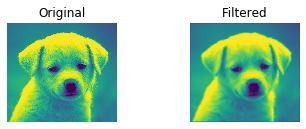

31x31 Gaussian filter, sigma=5


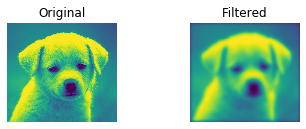

sharpening filter


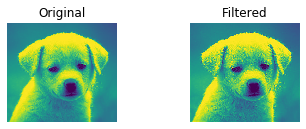

In [180]:
from scipy.signal import convolve


def filter1(img):
    """Convolve the image with a 5x5 Gaussian filter with sigma=5."""
    """ ==========
    YOUR CODE HERE
    ========== """
    kernel = gaussian2d(filter_size=5, sig=5)
    img_conv  = convolve(img, kernel, mode = "same")
    return img_conv
     

def filter2(img):
    """Convolve the image with a 31x31 Gaussian filter with sigma=5."""
    """ ==========
    YOUR CODE HERE
    ========== """
    kernel = gaussian2d(filter_size=31, sig=5)
    img_conv  = convolve(img, kernel, mode = "same")
    return img_conv
    

def filter3(img):
    """Convolve the image with the provided sharpening filter."""
    """ ==========
    YOUR CODE HERE
    ========== """
    
    kernel = np.array([
    [1, 4,     6,  4, 1],
    [4, 16,   24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16,   24, 16, 4],
    [1,  4,    6,  4, 1],
]) * -1.0 / 256.0
    kernel = np.flip(kernel,0)
    kernel = np.flip(kernel,1)
    img_conv  = convolve(img, kernel, mode = "same")

    return img_conv

for filter_name, filter_fn in [
    ('5x5 Gaussian filter, sigma=5', filter1),
    ('31x31 Gaussian filter, sigma=5', filter2),
    ('sharpening filter', filter3),
]:
    filtered = filter_fn(dog_img)
    print(filter_name)
    plot_results(dog_img, filtered)

### Part 2 [2 pts]

Display the Fourier log-magnitude transform image for the (original image, 31x31 Gaussian-filtered image) pair. (No need to include the others.) We have provided the code to compute the Fourier log-magnitude image.

Then, as a text answer, explain the differences you see between the original frequency domain image and the 31x31 Gaussian-filtered frequency domain image. In particular, be sure to address the following points:
- (A) Why is most of the frequency visualization dark after applying the Gaussian filter, and what does this signify?
- (B) What is an example of one of these dark images in the spatial domain (original image)?
- (C) What do the remaining bright regions in the magnitude image represent?
- (D) What is an example of one of these bright regions in the spatial domain (original image)?

31x31 Gaussian filter, sigma=5


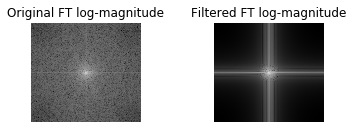

In [182]:
# Visualize the frequency domain images

def plot_ft_results(img1, img2):
    plt.subplot(2,2,1)
    plt.imshow(img1, cmap='gray')
    plt.title('Original FT log-magnitude')
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.imshow(img2, cmap='gray')
    plt.title('Filtered FT log-magnitude')
    plt.axis('off')

    plt.show()

def ft_log_magnitude(img_gray):
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(img_gray))))

print('31x31 Gaussian filter, sigma=5')
plot_ft_results(ft_log_magnitude(dog_img), 
                ft_log_magnitude(filter2(dog_img)))

### Your answer to Problem 2.2:

- (A) Why is most of the frequency visualization dark after applying the Gaussian filter, and what does this signify?
   
   Ans: because the image is blurred by the Gaussian filter, the image becomes less dramastic compared with the original image. Therefore, the image would be darker as a whole and the bright area would be more concentrated to the center.
   
   
- (B) What is an example of one of these dark images in the spatial domain (original image)?

    Ans: The darker area refers to higher frequency area in the spatial domain, namely, regions such as boundary or features of dogs would be good example representing dark area in the fourier domain.

- (C) What do the remaining bright regions in the magnitude image represent?
   
   Ans: areas remaining bright refers to regions whose value does not change a lot after smoothing.
   

- (D) What is an example of one of these bright regions in the spatial domain (original image)?

   Ans: The bright area refers to the region with low frequency, which might possibly be the background in the original image.

### Part 3 [3 pts]

Consider (1) smoothing an image with a 3x3 box filter and then computing the derivative in the y-direction (use the derivative filter from Lecture 7). Also consider (2) computing the derivative first, then smoothing. What is a single convolution kernel that will simultaneously implement both (1) and (2)?

### Your answer to Problem 2.3:

Ans: we know that a 3x3 box filter would be $$
boxKernel= \frac{1}{9}\left[ {\begin{array}{cc}
                 1 & 1 & 1 \\
                 1 & 1 & 1 \\
                 1 & 1 & 1 \\
                  \end{array} } \right]
$$
and a derivative filter in y-direction would be
$$
derivativeKernel= \left[ {\begin{array}{cc}
                 -\frac{1}{2}  \\
                 0   \\
                 \frac{1}{2}  \\
                  \end{array} } \right]
$$
Since convolution operation is communative, so the result of (1) and (2) would be the same regardless of the order. we can multiply two kernels to get  
$ \left[ {\begin{array}{cc}
    -\frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\
      0 & 0 & 0 \\
     \frac{1}{2} & \frac{1}{2} & \frac{1}{2}\\
     \end{array} } \right]$, which could be used to simultaneouly implement both (1) and (2).

### Part 4 [3 pts]

Give an example of a 3x3 separable filter and compare the number of arithmetic operations it takes to
convolve using that filter on an n × n image before and after separation.

### Your answer to Problem 2.4:

We can take box  filter as an example.

Original box filter(3x3) is
$$
Kbox = \frac{1}{9}\left[ {\begin{array}{cc}
                 1 & 1 & 1 \\
                 1 & 1 & 1 \\
                 1 & 1 & 1 \\
                  \end{array} } \right]
$$

After separation, we can have two 1d kernel as

$$
K1 = \frac{1}{3}\left[ {\begin{array}{cc}
                 1 & 1 & 1 \\
                  \end{array} } \right]
$$

$$
K2 = \frac{1}{3}\left[ {\begin{array}{cc}
                     1 \\
                     1 \\
                     1 \\
                  \end{array} } \right]                   
$$

$$ Kbox = K1*K2 $$

If we use the original box filter(3x3), each pixel in the original image would have to interact with each elements in the box filter, which means we have $3 * 3 * n^{2} = 9n^{2}$ arithmetic operations.

On the other hand, if we seperate the kernels we will first have to compute every pixel in images with elements in 1x3 kernel, then do again with elements in 3x1 kernel, so we will have $3 * n^{2} + 3 * n^{2} = 6* n^{2} = 6n^{2}$ arithmatic operations.

### Part 5: Filters as Templates [3.5 pts]

Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

Luckily, you have learned in CSE 252A (or are learning right now) that convolution can be used for template matching: a template g is multiplied with regions of a larger image f to measure how similar each region is to the template. Note that you will want to flip the filter before giving it to your convolution function, so that it is overall not flipped when making comparisons. You will also want to subtract off the mean value of the image or template (whichever you choose, subtract the same value from both the image and template) so that your solution is not biased toward higher-intensity (white) regions.

The template of a product (template.jpg) and the image of the shelf (shelf.jpg) is provided. We will use convolution to find the product in the shelf.

<img src="template.jpg" alt="template" width="25px"/>
<img src="shelf.jpg" alt="shelf" width="600px"/>

shape of temp:  (56, 39, 3)
shape of temp_gray:  (56, 39)


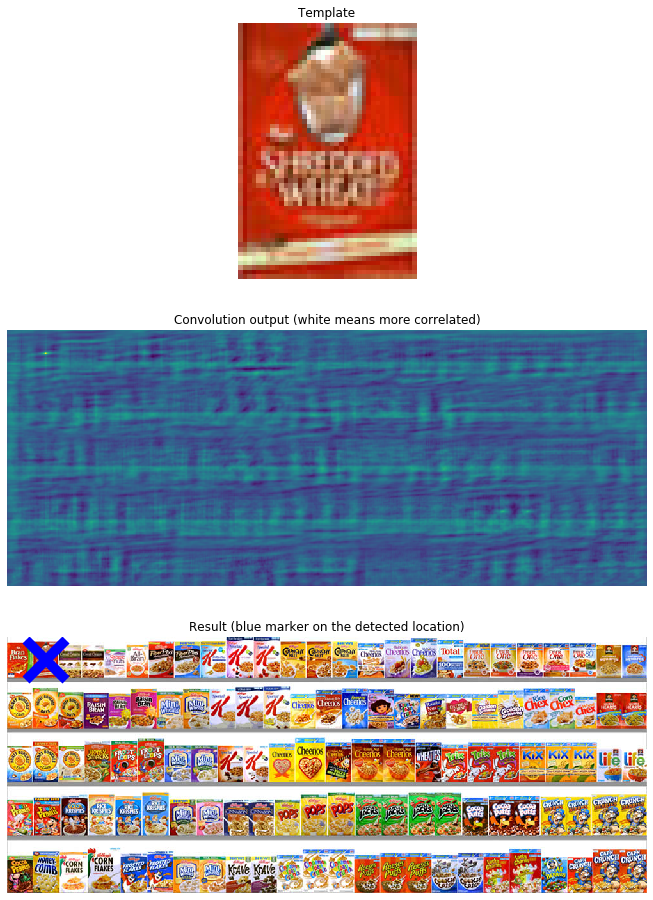

In [143]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import convolve
%matplotlib inline

# Load template and image in grayscale
img = io.imread('shelf.jpg')
img_gray = io.imread('shelf.jpg', as_gray=True)
temp = io.imread('template.jpg')
temp_gray = io.imread('template.jpg', as_gray=True)
print("shape of temp:  {}".format(temp.shape))
print("shape of temp_gray:  {}".format(temp_gray.shape))


# Perform a convolution between the image and the template
""" ==========
YOUR CODE HERE
========== """

kernel_mean = np.mean(temp_gray)
temp_gray = temp_gray - kernel_mean
img_gray = img_gray - kernel_mean
temp_gray = np.flip(temp_gray, 1)
temp_gray = np.flip(temp_gray, 0)
out = convolve(img_gray, temp_gray,mode ='same')

# Find the location with maximum similarity
y, x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(20,16))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display convolution output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Convolution output (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()

## Problem 3: Edge Detection [7 pts]

In this problem, you will write a function to perform edge detection. The following steps need to be implemented.

- **Smoothing [1 pt]:** First, we need to smooth the images to prevent noise from being considered edges. For this problem, use a 9x9 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

- **Gradient Computation [2 pts]:** After you have finished smoothing, find the image gradient in the horizontal and vertical directions. Compute the gradient magnitude image as $|G| = \sqrt{G_x^2 + G_y^2}$.

- **Non-Maximum Suppression [4 pts]:** We would like our edges to be sharp, unlike the ones in the gradient magnitude image from above. Use local non-maximum suppression on the gradient magnitude image to suppress all local non-maximum gradient magnitude values. To see how it affects the results, try using two different window sizes: 5x5 and 21x21.

Compute the images after each step. Show each of the intermediate steps and label your images accordingly.

In total, there should be five output images (original, smoothed, gradient magnitude, NMS result with 5x5 window, NMS result with 21x21 window).

**For this question, use the image `geisel.jpeg`.**

Original:


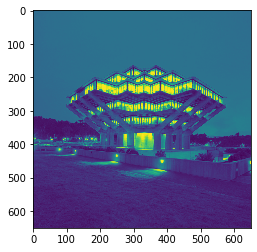

Smoothed:


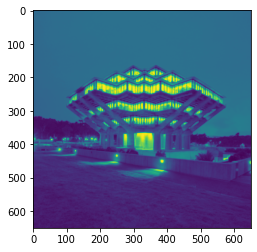

Gradient magnitude:


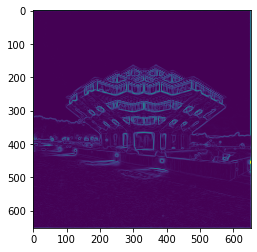

NMS with 5x5 window:


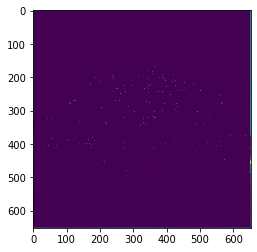

NMS with 21x21 window:


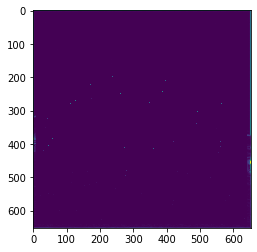

In [178]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

def smooth(img):
    """ ==========
    YOUR CODE HERE
    ========== """
    kernel = gaussian2d(filter_size=9, sig=1.4)
    img_conv  = convolve(img, kernel, mode = "same")
    return img_conv

def gradient(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    x_grad, y_grad  = np.zeros(image.shape), np.zeros(image.shape)
    M,N = image.shape
    x_grad_kernel = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    y_grad_kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    x_grad = convolve(image,x_grad_kernel)
    y_grad = convolve(image,y_grad_kernel)
    g_mag = (x_grad**2 + y_grad**2)**0.5
    g_theta = np.absolute((np.arctan(y_grad/x_grad)*180/np.pi)%180)
    return g_mag, g_theta

def nms(g_mag, g_theta, window_size=5):
    """ ==========
    YOUR CODE HERE
    ========== """
    w = int((window_size-1)/2)
    M , N = g_mag.shape
    img_nms = np.copy(g_mag)
    #img_nms = np.zeros(g_mag.shape)
    
    for i in range(M-window_size):
        for j in range(N-window_size):
            window = g_mag[i:i+window_size,j:j+window_size]
            if np.max(window) != window[w,w]:
                img_nms[i+w,j+w] = 0
    return img_nms

def edge_detect(image):
    """Perform edge detection on the image."""
    smoothed = smooth(image)
    g_mag, g_theta = gradient(smoothed)
    nms_image_5x5 = nms(g_mag, g_theta, window_size=5)
    nms_image_21x21 = nms(g_mag, g_theta, window_size=21)
    return smoothed, g_mag, nms_image_5x5, nms_image_21x21

# Load image in grayscale
image = io.imread('geisel.jpeg', as_gray=True)
smoothed, g_mag, nms_image_5x5, nms_image_21x21 = edge_detect(image)
#print("image.shape: ", image.shape)
print('Original:')
plt.imshow(image)
plt.show()

print('Smoothed:')
plt.imshow(smoothed)
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag)
plt.show()

print('NMS with 5x5 window:')
plt.imshow(nms_image_5x5)
plt.savefig('kernel5.png')
plt.show()

print('NMS with 21x21 window:')
plt.imshow(nms_image_21x21)
plt.savefig('kernel21.png')
plt.show()

---
## Submission Instructions
Remember to submit a PDF version of this notebook to Gradescope. Please make sure the contents of each cell are clearly shown in your final PDF file. **If they are not, we may dock points.**

There are multiple options for converting the notebook to PDF:
1. You can export using LaTeX (File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX).
2. You can first export as HTML and then save it as a PDF.